In [20]:
import os
from biosignal_analysis_tools import *
from scipy.io import loadmat
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import signal
from scipy.signal import correlate

emg_path = "/home/tipu/Downloads/EEG-EMG-Data/EEG-EMG-Data/EEG-EMG Dataset IEEE/BMIS_EMG_DATA"
eeg_path = "/home/tipu/Downloads/EEG-EMG-Data/EEG-EMG-Data/EEG-EMG Dataset IEEE/BMIS_EEG_DATA"

class Scale:
    mini_volt = 1000
    micro_volt = 1000000


# Helper functions for delay estimation and alignment
def find_time_delay(eeg_signal, emg_signal, sampling_rate):
    """
    Estimate the time delay between EEG and EMG signals using cross-correlation.
    """
    correlation = correlate(eeg_signal, emg_signal, mode='full')
    lag_samples = correlation.argmax() - (len(emg_signal) - 1)
    time_delay = lag_samples / sampling_rate
    return time_delay, lag_samples


def align_signals(eeg_signal, emg_signal, lag_samples):
    """
    Align EMG signal with EEG signal based on the estimated lag.
    """
    if lag_samples > 0:
        emg_signal_aligned = np.pad(emg_signal, (lag_samples, 0))[:len(eeg_signal)]
    elif lag_samples < 0:
        eeg_signal = np.pad(eeg_signal, (-lag_samples, 0))[:len(emg_signal)]
        emg_signal_aligned = emg_signal
    else:
        emg_signal_aligned = emg_signal

    return eeg_signal, emg_signal_aligned


# Functions to load EEG and EMG files for a specific subject and gestures
def get_emg_per_subject_file(subject, no_gesture):
    base_path = os.path.join(emg_path, f"data/mat_data/subject_{subject}")
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Directory does not exist: {base_path}")
    
    data_file = os.listdir(base_path)
    gesture = {}
    for i in range(no_gesture):
        j = i + 1
        gesture[str(i)] = [file for file in data_file if str(j) in file]
    return base_path, gesture


def get_eeg_per_subject_file(subject, no_gesture):
    base_path = os.path.join(eeg_path, f"data/mat_data/subject_{subject}")
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Directory does not exist: {base_path}")
    
    data_file = os.listdir(base_path)
    gesture = {}
    for i in range(no_gesture):
        j = i + 1
        gesture[str(i)] = [file for file in data_file if str(j) in file]
    return base_path, gesture


def get_emg_data_per_gesture(subject, no_gesture):
    path, filename = get_emg_per_subject_file(subject, no_gesture)
    gesture = {}

    for i in filename:
        for inx, j in enumerate(filename[i]):
            data = loadmat(os.path.join(path, j))['data']
            if inx == 0:
                stack_data = data
            else:
                stack_data = np.row_stack((stack_data, data))
        gesture[str(i)] = stack_data
    return gesture


def get_eeg_data_per_gesture(subject, no_gesture):
    path, filename = get_eeg_per_subject_file(subject, no_gesture)
    gesture = {}

    for i in filename:
        for inx, j in enumerate(filename[i]):
            data = loadmat(os.path.join(path, j))['data'].transpose()
            if inx == 0:
                stack_data = data
            else:
                stack_data = np.row_stack((stack_data, data))
        stack_data = stack_data / Scale.micro_volt
        gesture[str(i)] = stack_data
    return gesture


# Preprocessing functions for EEG and EMG
def pre_processing_emg(data, emg_fs, notch_freq, quality_factor, fc, fh, order):
    notched_data = mains_removal(data, fs=emg_fs, notch_freq=notch_freq, quality_factor=quality_factor)
    filtered_data = butter_bandpass_filter(notched_data, lowcut=fc, highcut=fh, fs=emg_fs, order=order)
    if filtered_data.any() < 0:
        filtered_data = filtered_data / -128.0
    else:
        filtered_data = filtered_data / 127.0
    return filtered_data.transpose()


def pre_processing_eeg(data, eeg_fs, notch_freq, quality_factor, fc, fh, order):
    notched_data = mains_removal(data, fs=eeg_fs, notch_freq=notch_freq, quality_factor=quality_factor)
    filtered_data = butter_bandpass_filter(notched_data, lowcut=fc, highcut=fh, fs=eeg_fs, order=order)
    filtered_data = filtered_data[250:, :]
    return filtered_data.transpose()


# Segmentation function
def window_with_overlap(data, sampling_frequency=250, window_time=1000, overlap=60, no_channel=8):
    samples = int(sampling_frequency * (window_time / 1000))
    num_overlap = int(samples * (overlap / 100))
    num_overlap_samples = samples - num_overlap
    idx = [i for i in range(samples, data.shape[1], num_overlap_samples)]

    data_matrix = np.zeros([len(idx), no_channel, samples])
    for i, end in enumerate(idx):
        start = end - samples
        if end <= data.shape[1]:
            data_matrix[i] = data[0:no_channel, start:end]
    return data_matrix


def create_label(data, inx):
    label = np.zeros([data.shape[0], 1])
    label.fill(int(inx))
    return label


def shuffle_data(data_emg, data_eeg, label):
    """
    Shuffle EMG, EEG, and label data while ensuring size consistency.
    """
    # Ensure all arrays have the same size
    min_size = min(len(data_emg), len(data_eeg), len(label))
    data_emg = data_emg[:min_size]
    data_eeg = data_eeg[:min_size]
    label = label[:min_size]

    # Generate shuffled indices
    idx = np.random.permutation(len(data_eeg))
    
    # Shuffle the data
    return data_emg[idx], data_eeg[idx], label[idx]


def get_data_subject_specific(subject, no_gesture, emg_fs, eeg_fs,
                              notch_freq, quality_factor, emg_fc, emg_fh,
                              eeg_fc, eeg_fh, order, window_time, overlap, no_channel):
    dict_gestures_emg = get_emg_data_per_gesture(subject, no_gesture)
    dict_gestures_eeg = get_eeg_data_per_gesture(subject, no_gesture)

    for idx, inx in enumerate(dict_gestures_emg):
        data_emg = pre_processing_emg(dict_gestures_emg[inx], emg_fs, notch_freq, quality_factor, emg_fc, emg_fh, order)
        data_eeg = pre_processing_eeg(dict_gestures_eeg[inx], eeg_fs, notch_freq, quality_factor, eeg_fc, eeg_fh, order)

        time_delay, lag_samples = find_time_delay(data_eeg[0, :], data_emg[0, :], eeg_fs)
        print(f"Gesture {inx}: Estimated Time Delay: {time_delay:.4f} seconds, Lag: {lag_samples} samples")
        data_eeg, data_emg = align_signals(data_eeg, data_emg, lag_samples)

        win_data_emg = window_with_overlap(data=data_emg, sampling_frequency=emg_fs, window_time=window_time,
                                           overlap=overlap, no_channel=no_channel)
        win_data_eeg = window_with_overlap(data=data_eeg, sampling_frequency=eeg_fs, window_time=window_time,
                                           overlap=overlap, no_channel=no_channel)
        label = create_label(win_data_emg, inx)

        if idx == 0:
            data_stack_emg = win_data_emg
            data_stack_eeg = win_data_eeg
            label_stack = label
        else:
            data_stack_emg = np.row_stack((data_stack_emg, win_data_emg))
            data_stack_eeg = np.row_stack((data_stack_eeg, win_data_eeg))
            label_stack = np.row_stack((label_stack, label))

    # Debugging: Check array shapes before shuffling
    print(f"Final EMG shape: {data_stack_emg.shape}")
    print(f"Final EEG shape: {data_stack_eeg.shape}")
    print(f"Final Label shape: {label_stack.shape}")

    # Shuffle data
    X_emg, X_eeg, y = shuffle_data(data_stack_emg, data_stack_eeg, label_stack)
    return X_emg, X_eeg, y



In [21]:
import pandas as pd

def export_to_csv(data_eeg, data_emg, labels, output_dir="output"):
    """
    Export EEG, EMG, and labels to CSV files.

    Args:
        data_eeg (np.ndarray): EEG data array with shape (samples, channels, time).
        data_emg (np.ndarray): EMG data array with shape (samples, channels, time).
        labels (np.ndarray): Labels array with shape (samples, 1).
        output_dir (str): Directory where CSV files will be saved.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Flatten the EEG and EMG data to 2D (samples, features)
    num_samples, num_channels, num_time_points = data_eeg.shape
    eeg_flattened = data_eeg.reshape(num_samples, -1)  # (samples, channels * time)
    emg_flattened = data_emg.reshape(num_samples, -1)  # (samples, channels * time)

    # Convert to DataFrame
    eeg_df = pd.DataFrame(eeg_flattened, columns=[f"EEG_{i}" for i in range(eeg_flattened.shape[1])])
    emg_df = pd.DataFrame(emg_flattened, columns=[f"EMG_{i}" for i in range(emg_flattened.shape[1])])
    labels_df = pd.DataFrame(labels, columns=["Label"])

    # Save to CSV
    eeg_df.to_csv(os.path.join(output_dir, "eeg_data.csv"), index=False)
    emg_df.to_csv(os.path.join(output_dir, "emg_data.csv"), index=False)
    labels_df.to_csv(os.path.join(output_dir, "labels.csv"), index=False)

    print(f"EEG data saved to {os.path.join(output_dir, 'processed_eeg_data.csv')}")
    print(f"EMG data saved to {os.path.join(output_dir, 'processed_emg_data.csv')}")
    print(f"Labels saved to {os.path.join(output_dir, 'labels.csv')}")


# Example Usage
subject = 1
no_gesture = 7
emg_fs = 200
eeg_fs = 250
notch_freq = 60
quality_factor = 30
emg_fc, emg_fh = 5, 50
eeg_fc, eeg_fh = 1, 50
order = 4
window_time = 1000  # ms
overlap = 60  # percentage
no_channel = 8

# Process the data for the specific subject
X_emg, X_eeg, y = get_data_subject_specific(subject, no_gesture, emg_fs, eeg_fs, notch_freq, quality_factor,
                                             emg_fc, emg_fh, eeg_fc, eeg_fh, order, window_time, overlap, no_channel)

# Export the data to CSV files
export_to_csv(X_eeg, X_emg, y, output_dir="processed_data")


Gesture 0: Estimated Time Delay: 14.6040 seconds, Lag: 3651 samples
Gesture 1: Estimated Time Delay: -3.3280 seconds, Lag: -832 samples
Gesture 2: Estimated Time Delay: -11.6800 seconds, Lag: -2920 samples
Gesture 3: Estimated Time Delay: -3.8400 seconds, Lag: -960 samples
Gesture 4: Estimated Time Delay: -25.2840 seconds, Lag: -6321 samples
Gesture 5: Estimated Time Delay: 27.8320 seconds, Lag: 6958 samples
Gesture 6: Estimated Time Delay: -15.2600 seconds, Lag: -3815 samples
Final EMG shape: (2260, 8, 200)
Final EEG shape: (1467, 8, 250)
Final Label shape: (2260, 1)
EEG data saved to processed_data/processed_eeg_data.csv
EMG data saved to processed_data/processed_emg_data.csv
Labels saved to processed_data/labels.csv


In [22]:

# Load the datasets
eeg_data = pd.read_csv('processed_eeg_data.csv')
emg_data = pd.read_csv('processed_emg_data.csv')
labels = pd.read_csv('labels.csv')


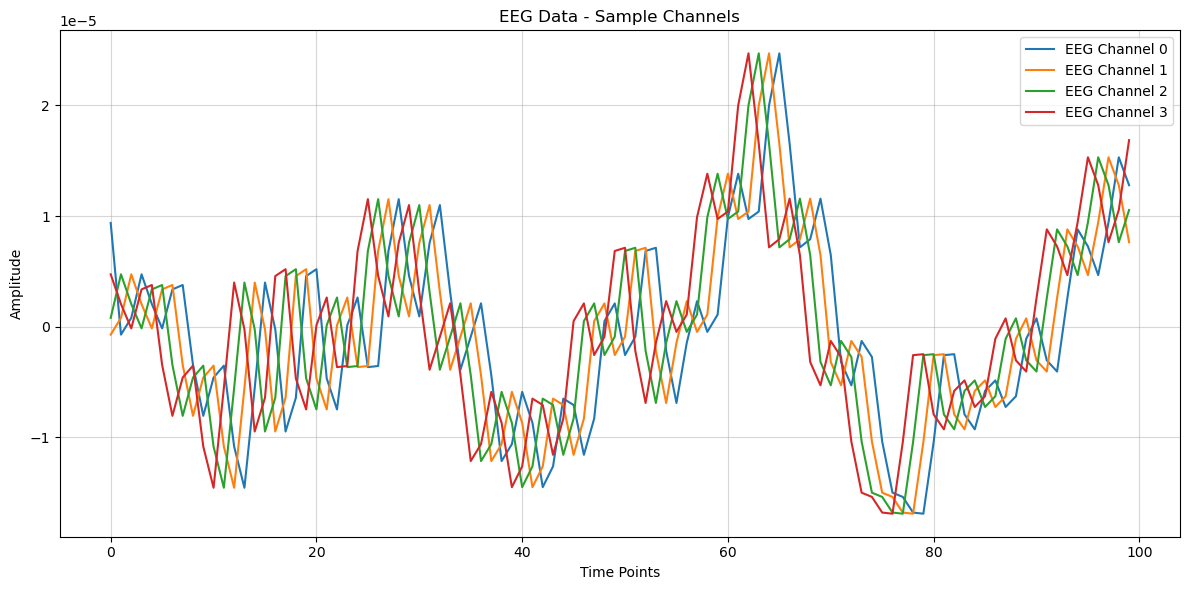

In [23]:
# Plot EEG Data
plt.figure(figsize=(12, 6))

# Plot the first few EEG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(eeg_data.iloc[0, channel:channel+100].values, label=f'EEG Channel {channel}')

plt.title('EEG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


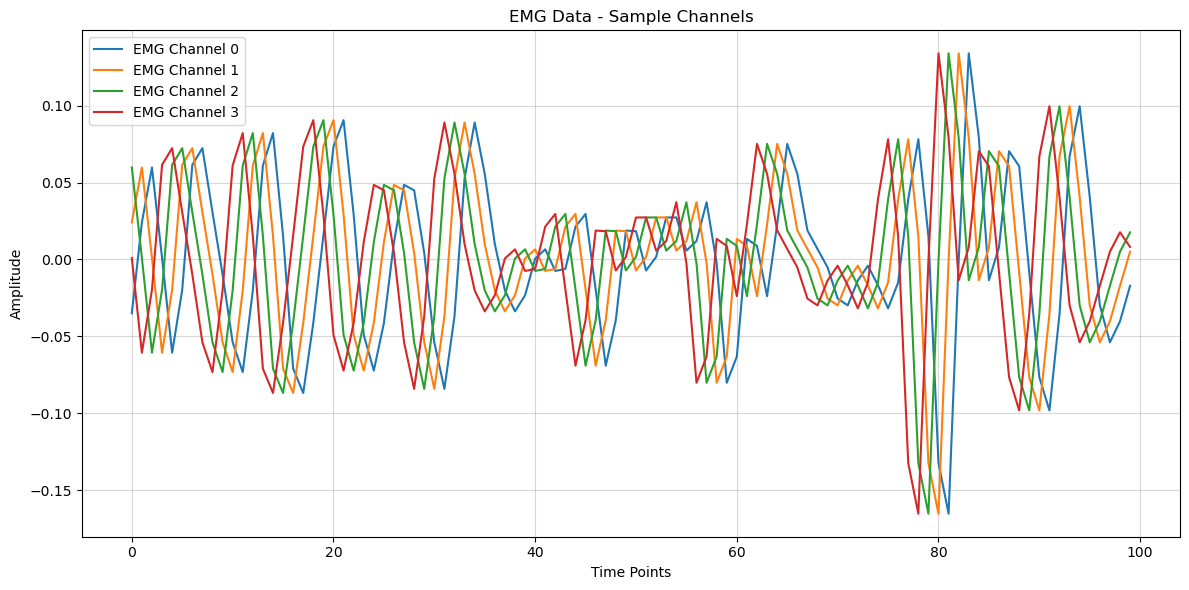

In [24]:
# Load the EMG dataset
emg_data = pd.read_csv('processed_emg_data.csv')

# Plot EMG Data
plt.figure(figsize=(12, 6))

# Plot the first few EMG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(emg_data.iloc[0, channel:channel+100].values, label=f'EMG Channel {channel}')

plt.title('EMG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


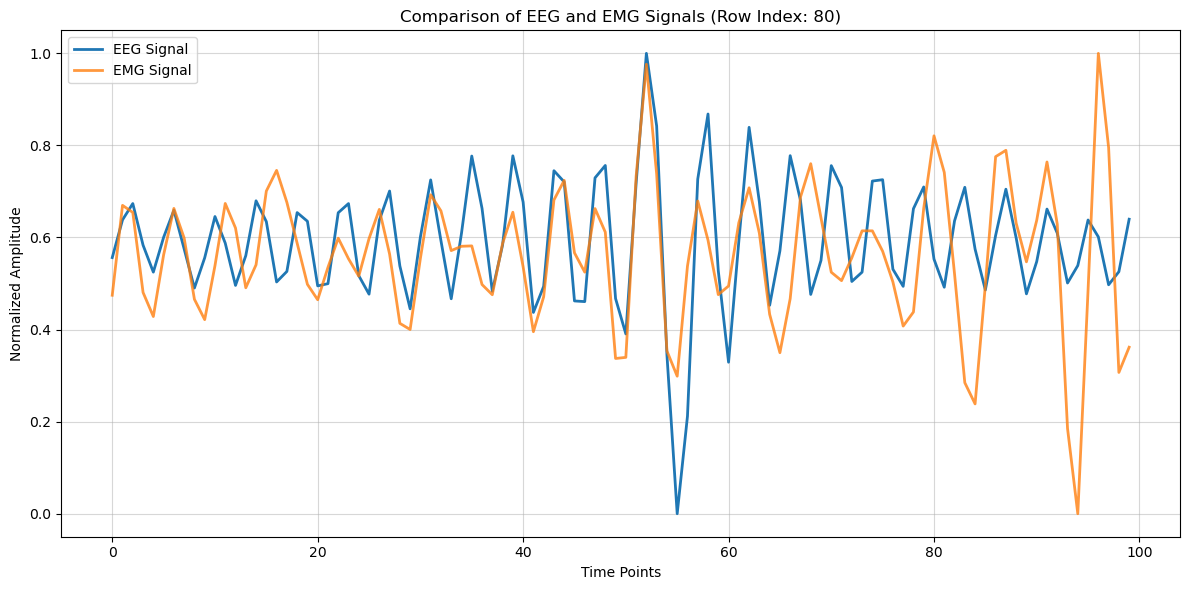

In [25]:
# Select a specific row to plot
row_index = 80  # Change this to select a different row
eeg_signal = eeg_data.iloc[row_index, :100].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :100].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [26]:
eeg_duplicates = eeg_data.duplicated().sum()
emg_duplicates = emg_data.duplicated().sum()
label_duplicates = labels.duplicated().sum()


In [27]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 118
Number of duplicate rows in Labels: 483


In [28]:
# Load the EMG data
emg_data = pd.read_csv('processed_emg_data.csv')

# Find duplicate rows
duplicates = emg_data.duplicated(keep=False)

# Add a small random perturbation to duplicate rows
emg_data.loc[duplicates] = emg_data.loc[duplicates] + np.random.normal(0, 0.001, emg_data.loc[duplicates].shape)

# Save the modified data
emg_data.to_csv('processed_emg_data1.csv', index=False)

print("Duplicates have been made unique and saved as 'processed_emg_data1.csv'.")


Duplicates have been made unique and saved as 'processed_emg_data1.csv'.


In [29]:
emg_duplicates = emg_data.duplicated().sum()
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")

Number of duplicate rows in EMG data: 0


In [30]:
# Load the datasets
eeg_data = pd.read_csv('processed_eeg_data.csv')
emg_data = pd.read_csv('processed_emg_data1.csv')
labels = pd.read_csv('labels.csv')

# Data augmentation functions
def add_noise(data, noise_level=0.01):
    """Add random noise to the data."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scale_data(data, scale_factor=1.1):
    """Scale the data."""
    return data * scale_factor

def time_shift(data, shift):
    """Shift the data along the time axis."""
    return np.roll(data, shift, axis=0)

def flip_data(data):
    """Flip the data vertically."""
    return -data

# Apply augmentations
augmented_eeg = []
augmented_emg = []
augmented_labels = []

for i in range(len(eeg_data)):
    eeg_row = eeg_data.iloc[i].values
    emg_row = emg_data.iloc[i].values
    label = labels.iloc[i].values[0]

    # Original data
    augmented_eeg.append(eeg_row)
    augmented_emg.append(emg_row)
    augmented_labels.append(label)

    # Augmentation 1: Add noise
    augmented_eeg.append(add_noise(eeg_row))
    augmented_emg.append(add_noise(emg_row))
    augmented_labels.append(label)

    # Augmentation 2: Scale data
    augmented_eeg.append(scale_data(eeg_row))
    augmented_emg.append(scale_data(emg_row))
    augmented_labels.append(label)

    # Augmentation 3: Time shift
    augmented_eeg.append(time_shift(eeg_row, shift=5))
    augmented_emg.append(time_shift(emg_row, shift=5))
    augmented_labels.append(label)

    # Augmentation 4: Flip data
    augmented_eeg.append(flip_data(eeg_row))
    augmented_emg.append(flip_data(emg_row))
    augmented_labels.append(label)

# Convert augmented data to DataFrame
augmented_eeg_df = pd.DataFrame(augmented_eeg, columns=eeg_data.columns)
augmented_emg_df = pd.DataFrame(augmented_emg, columns=emg_data.columns)
augmented_labels_df = pd.DataFrame(augmented_labels, columns=['Label'])

# Save augmented data
augmented_eeg_df.to_csv('augmented_eeg_data.csv', index=False)
augmented_emg_df.to_csv('augmented_emg_data.csv', index=False)
augmented_labels_df.to_csv('augmented_labels.csv', index=False)

print("Data augmentation completed. Augmented files saved.")


Data augmentation completed. Augmented files saved.


In [31]:
# Load the datasets
eeg_data = pd.read_csv('augmented_eeg_data.csv')
emg_data = pd.read_csv('augmented_emg_data.csv')
labels = pd.read_csv('augmented_labels.csv')

In [32]:
eeg_duplicates = eeg_data.duplicated().sum()
emg_duplicates = emg_data.duplicated().sum()
label_duplicates = labels.duplicated().sum()


In [33]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 0
Number of duplicate rows in Labels: 2443


Label Distribution:
Label
5.0    350
1.0    350
4.0    350
2.0    350
6.0    350
3.0    350
0.0    350
Name: count, dtype: int64


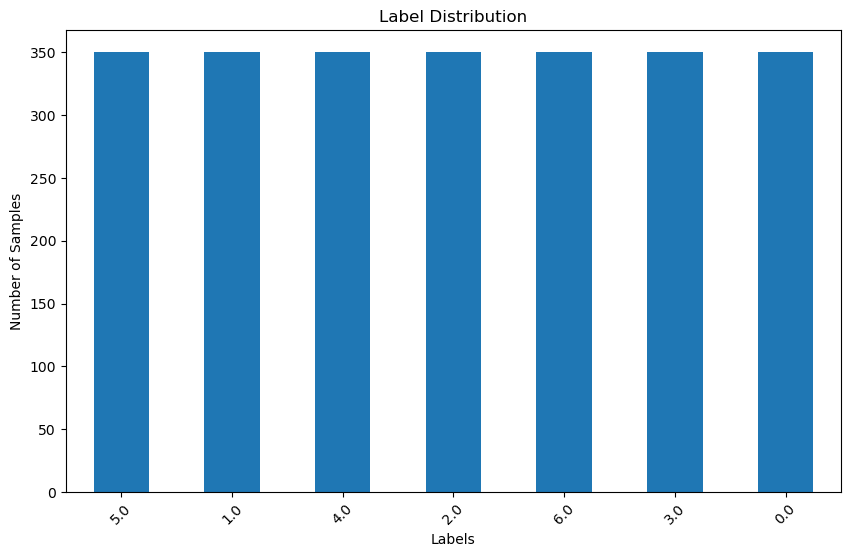


Maximum label count: 350
Minimum label count: 350
Difference between max and min counts: 0

The dataset is fairly balanced.


In [34]:
import matplotlib.pyplot as plt
# Check the distribution of labels
label_distribution = labels['Label'].value_counts()

# Display the distribution
print("Label Distribution:")
print(label_distribution)

# Plot the label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Check for balance
max_count = label_distribution.max()
min_count = label_distribution.min()
print("\nMaximum label count:", max_count)
print("Minimum label count:", min_count)
print("Difference between max and min counts:", max_count - min_count)

if max_count - min_count <= 0.1 * max_count:
    print("\nThe dataset is fairly balanced.")
else:
    print("\nThe dataset is imbalanced. Consider applying techniques to balance it.")

In [35]:
# Load the datasets
eeg_data = pd.read_csv('augmented_eeg_data.csv')
emg_data = pd.read_csv('augmented_emg_data.csv')
labels = pd.read_csv('augmented_labels.csv')

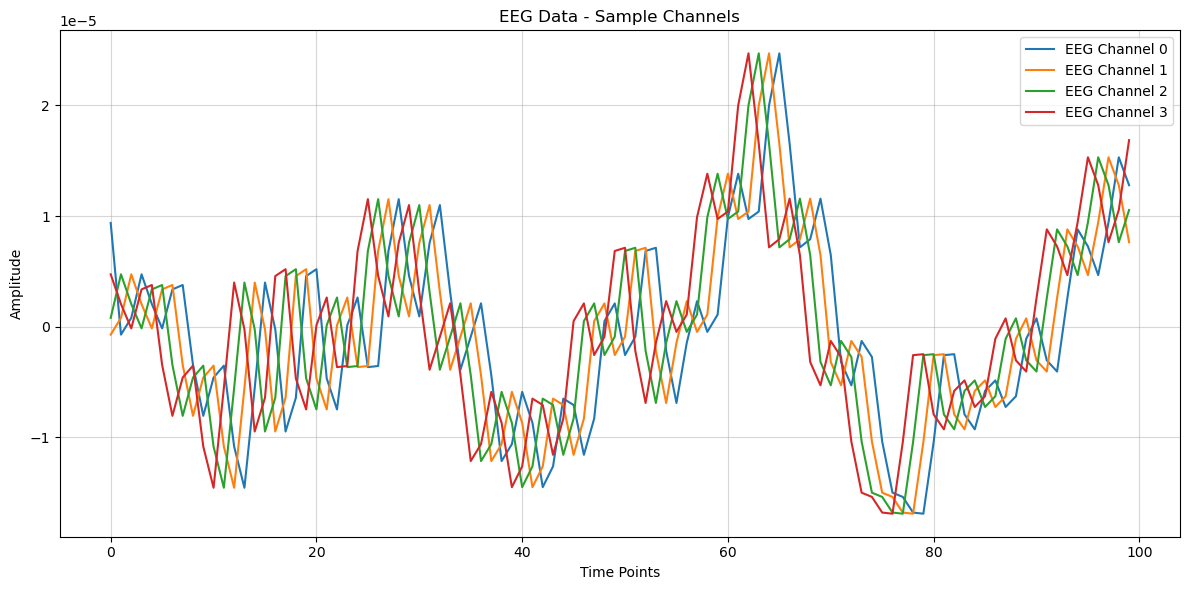

In [36]:
# Plot EEG Data
plt.figure(figsize=(12, 6))

# Plot the first few EEG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(eeg_data.iloc[0, channel:channel+100].values, label=f'EEG Channel {channel}')

plt.title('EEG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


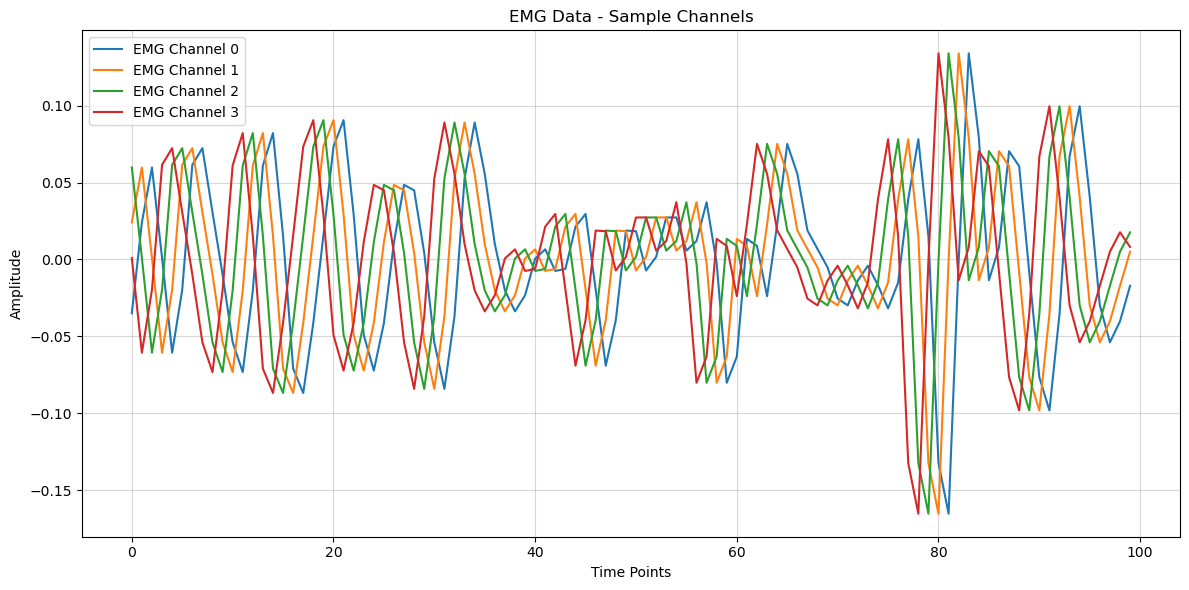

In [37]:
# Load the EMG dataset
emg_data = pd.read_csv('processed_emg_data.csv')

# Plot EMG Data
plt.figure(figsize=(12, 6))

# Plot the first few EMG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(emg_data.iloc[0, channel:channel+100].values, label=f'EMG Channel {channel}')

plt.title('EMG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


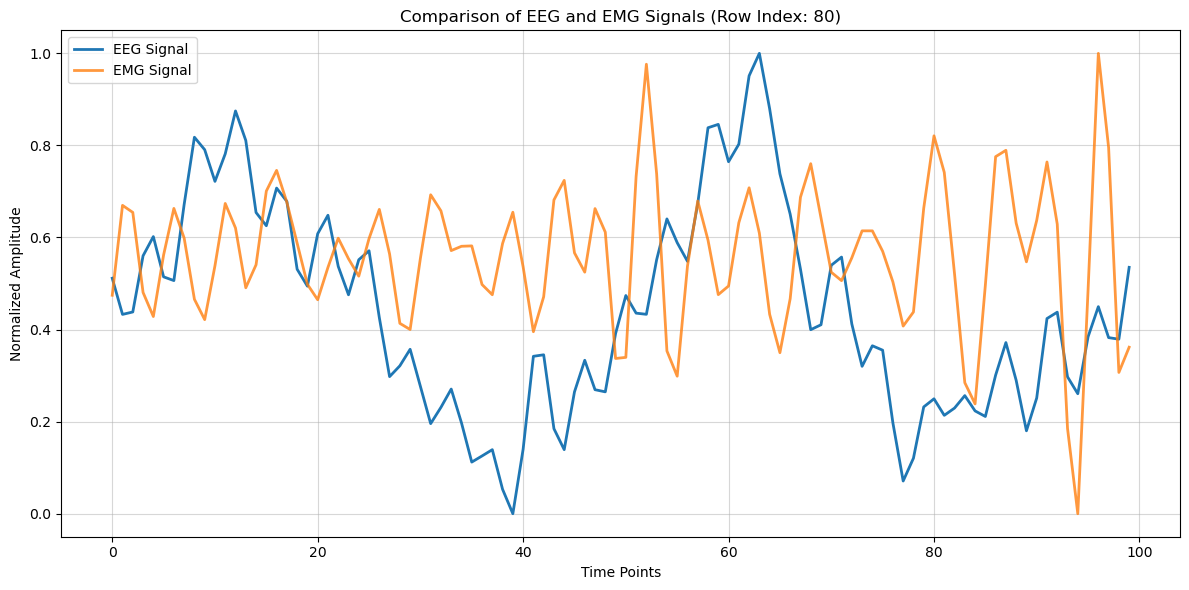

In [38]:
# Select a specific row to plot
row_index = 80  # Change this to select a different row
eeg_signal = eeg_data.iloc[row_index, :100].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :100].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()
